# Predição de votação do Poder Legislativo

O objetivo deste lab é obter um modelo que preveja a votação de Deputados Federais, baseado em votações anteriores (2006 e 2010).

### Análise descritiva dos dados

Para que se entenda a organização e distribuição dos dados, além de um primeiro tratamento de inconsistências, faz-se aqui uma análise descritiva simples, utilizando as bibliotecas `numpy` e `pandas`.

In [1]:
import pandas as pd
import numpy as np


# carregar dataset
data = pd.read_csv("eleicoes_2006_a_2010.csv")

Descrevendo o conjunto de dados: primeiro, colunas numéricas:

In [2]:
data.describe(include='number')

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7.330000e+03,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,9.179127e+10,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,9.924629e+10,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000100e+04,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,1.056500e+04,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,5.000000e+10,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,1.900000e+11,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,2.700000e+11,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


Agora, colunas categóricas:

In [3]:
data.describe(include='object')

,nome,uf,partido,cargo,sexo,grau,estado_civil,ocupacao
count,7330,7330,7330,7330,7330,7330,7330,7330
unique,6775,27,31,1,2,7,5,175
top,FRANCISCO LOPES DA SILVA,SP,PT,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),OUTROS
freq,3,1623,606,7330,6305,4255,4704,819


Observemos a distribuição da variável-alvo, que é `votos`. Por estar bastante enviesada (gráfico da direita), aplicamos `log(votos+1)` para deixá-la mais próxima da normalidade (gráfico da esquerda):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119f34710>,
      dtype=object)

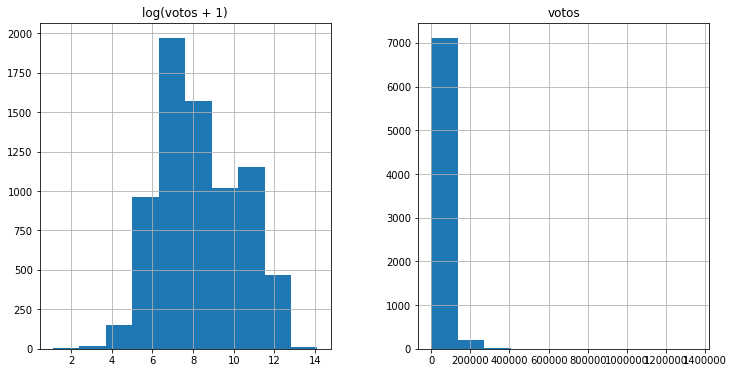

In [5]:
import matplotlib

import matplotlib.pyplot as plt

%matplotlib inline


matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
votos = pd.DataFrame({"votos":data["votos"], "log(votos + 1)":np.log1p(data["votos"])})
votos.hist()

Aplicamos a função `log(votos + 1)` na variável-alvo. Além disso, aplicamos a mesma função em todos os atributos numéricos que estejam enviesados. Primeiro, calculamos o quão enviesados eles estão, aplicando `log(atributo + 1)` a todos cuja taxa exceda `0.75`:

In [9]:
from scipy.stats import skew


# todo: separar dados em treino e teste.
# aplicando log(feature + 1) na variável-alvo
data['votos'] = np.log1p(data['votos'])

atr_numericos = data.dtypes[data.dtypes != 'object'].index

atr_enviesados = data[atr_numericos].apply(lambda x: skew(x.dropna()))
atr_enviesados = atr_enviesados[atr_enviesados > 0.75]
atr_enviesados = atr_enviesados.index

data[atr_enviesados] = np.log1p(data[atr_enviesados])

Convertamos variáveis categóricas para variáveis _dummy_:

In [13]:
data = pd.get_dummies(data)

Como há muitas variáveis numéricas sem valor (`NA`) definido, substituam-se os valores indefinidos pelas médias das respectivas colunas:

In [17]:
data = data.fillna(data.mean())